In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from stix2.v21 import (ThreatActor, Identity, AttackPattern, Campaign, IntrusionSet, Relationship, ExternalReference, Bundle, Grouping)
from efficient_apriori import apriori
import re

In [38]:
# DETERMINE APPROPRIATE INPUT VALUES
# frame story over using actor as initial seed, use actor's TTPs as intel seed
# Settings Values - for apriori algorithm
confidenceLevel = 0.70
supportLevel = 0.05

# initial actor value to build the activity attack-graph from 
intelSeed = "G0079"

In [4]:
df = pd.read_csv("Categorized_Adversary_TTPs.csv") # sample dataset of attacks
df.head()

,mitre_attack_id,mitre_attack_name,mitre_attack_aliases,mitre_attack_created,mitre_attack_last_modified,etda_id,etda_name,etda_aliases,etda_first_seen,country,motivation,victim_industries,victim_countries,mitre_attack_ttps
0,intrusion-set--dc5e2999-ca1a-47d4-8d12-a6984b1...,UNC2452,"['UNC2452', 'NOBELIUM', 'StellarParticle', 'Da...",2021-01-05,2021-05-04,93ba9804-335e-4782-855d-40af22b93201,"APT 29, Cozy Bear, The Dukes","['APT 29', 'Cozy Bear', 'The Dukes', 'Group 10...",2008,RU,['Information theft and espionage'],"['Defense', 'Energy', 'Government', 'Law enfor...","['Australia', 'Azerbaijan', 'Belarus', 'Belgiu...","['T1484.002', 'T1071.001', 'T1053.005', 'T1036..."
1,intrusion-set--8f5e8dc7-739d-4f5e-a8a1-a66e004...,Cleaver,"['Cleaver', 'Threat Group 2889', 'TG-2889']",2017-05-31,2021-10-12,4622bc44-8c01-4807-8d12-b22352472c29,"Cutting Kitten, TG-2889","['Cutting Kitten', 'TG-2889', 'Operation “Clea...",2012,IR,['Information theft and espionage'],"['Aerospace', 'Aviation', 'Chemical', 'Defense...","['Canada', 'China', 'France', 'Germany', 'Indi...","['T1588.002', 'T1003.001', 'T1587.001', 'T1585..."
2,intrusion-set--0ea72cd5-ca30-46ba-bc04-378f701...,GCMAN,['GCMAN'],2017-05-31,2020-03-30,e6eeb30a-a941-46f9-8340-20958f1d6cb0,GCMAN,['GCMAN'],2016,RU,['Financial crime'],['Financial'],['Russia'],"['T1021.005', 'T1021.004']"
3,intrusion-set--dd2d9ca6-505b-4860-a604-233685b...,Wizard Spider,"['Wizard Spider', 'UNC1878', 'TEMP.MixMaster',...",2020-05-12,2021-10-14,480940e0-47b0-4295-9067-c2500ccfdaec,"Wizard Spider, Gold Blackburn","['Wizard Spider', 'Grim Spider', 'TEMP.MixMast...",2014,RU,"['Financial crime', 'Financial gain']","['Defense', 'Financial', 'Government', 'Health...",None Provided,"['T1053.005', 'T1033', 'T1070.004', 'T1059.003..."
4,intrusion-set--f9d6633a-55e6-4adc-9263-6ae0804...,Magic Hound,"['Magic Hound', 'TA453', 'COBALT ILLUSION', 'C...",2018-01-16,2022-04-17,bb9b25ed-9ddc-4f65-bd01-ab8d6efc34ac,"Magic Hound, APT 35, Cobalt Gypsy, Charming Ki...","['Magic Hound', 'APT 35', 'Cobalt Illusion', '...",2012,IR,['Information theft and espionage'],"['Defense', 'Energy', 'Financial', 'Government...","['Afghanistan', 'Canada', 'Egypt', 'Iran', 'Ir...","['T1071', 'T1564.003', 'T1560.001', 'T1586.002..."


In [5]:
# tactics = pd.read_csv("enterprise-attack-v12.1-tactics.csv") # list of all possible tactics
# tactics.head()

In [6]:
# techniques = pd.read_csv("enterprise-attack-v12.1-techniques.csv") # list of all possible techniques 
# techniques.head()

In [59]:
# to use the apriori we need to generate a list of lists
aprList = []
for row in df.values:
    aprList.append((row[13].strip('][').split(', ')))

In [8]:
from pyattck import Attck

attack = Attck()

#dictionary for high speed access
actors = {}
for actor in attack.enterprise.actors:
    actors[actor.id] = actor
malwares = attack.enterprise.malwares + attack.enterprise.tools
ttpLists = []
for malware in malwares:
    ttpLists.append(["'" + ttp.id + "'" for ttp in malware.techniques])

In [9]:
for i in range(0,10):
    print(ttpLists[i])

["'T1562.001'", "'T1046'"]
["'T1210'", "'T1105'", "'T1005'", "'T1112'", "'T1055.012'", "'T1087.003'", "'T1021.005'", "'T1497.003'", "'T1036'", "'T1542.003'", "'T1553.002'", "'T1041'", "'T1007'", "'T1495'", "'T1559.001'", "'T1566.002'", "'T1110.004'", "'T1106'", "'T1082'", "'T1008'", "'T1069'", "'T1562.001'", "'T1059.001'", "'T1135'", "'T1033'", "'T1132.001'", "'T1083'", "'T1065'", "'T1016'", "'T1018'", "'T1071.001'", "'T1185'", "'T1219'", "'T1555.005'", "'T1055'", "'T1552.001'", "'T1204.002'", "'T1555.003'", "'T1056.004'", "'T1027'", "'T1057'", "'T1543.003'", "'T1571'", "'T1087.001'", "'T1090.002'", "'T1059.003'", "'T1482'", "'T1140'", "'T1566.001'", "'T1053.005'", "'T1027.002'", "'T1552.002'", "'T1547.001'", "'T1573.001'"]
["'T1124'", "'T1485'", "'T1082'", "'T1010'", "'T1564.004'", "'T1027.003'", "'T1218.011'", "'T1105'", "'T1547.001'", "'T1033'", "'T1057'", "'T1083'", "'T1059.003'", "'T1016'", "'T1070.004'"]
["'T1016'", "'T1489'", "'T1562.001'", "'T1486'", "'T1490'", "'T1027'", "'T10

In [60]:
aprList += ttpLists
len(aprList)

746

In [61]:
#short visual of lists
for i in range(50,52):
    print(aprList[i])

["'T1036.002'", "'T1036.005'", "'T1583.001'", "'T1566.001'", "'T1204.002'", "'T1588.002'"]
["'T1070.004'", "'T1053.003'", "'T1046'", "'T1543.002'", "'T1562.001'", "'T1071'", "'T1037'", "'T1059.006'", "'T1027.002'", "'T1071.001'", "'T1547.001'", "'T1057'", "'T1018'", "'T1027'", "'T1105'", "'T1070.002'", "'T1059.004'", "'T1222.002'", "'T1055.002'", "'T1102'", "'T1027.004'", "'T1082'", "'T1552.004'", "'T1014'", "'T1574.006'", "'T1070.006'", "'T1140'", "'T1564.001'", "'T1190'", "'T1102.001'", "'T1496'", "'T1036.005'", "'T1571'", "'T1021.004'", "'T1562.004'", "'T1518.001'"]


In [44]:
# what if we try to use more abstract data by removing sub techniques 
for i in range(0,len(aprList)):
    aprList[i] = [re.sub(r'\.[0-9]+', '', ttp) for ttp in aprList[i]]

print(aprList[0:10])

[["'T1484'", "'T1071'", "'T1053'", "'T1036'", "'T1584'", "'T1195'", "'T1606'", "'T1016'", "'T1105'", "'T1114'", "'T1070'", "'T1069'", "'T1082'", "'T1074'", "'T1190'", "'T1552'", "'T1482'", "'T1003'", "'T1140'", "'T1558'", "'T1568'", "'T1562'", "'T1059'", "'T1560'", "'T1562'", "'T1021'", "'T1562'", "'T1036'", "'T1059'", "'T1587'", "'T1048'", "'T1098'", "'T1550'", "'T1133'", "'T1070'", "'T1098'", "'T1583'", "'T1018'", "'T1027'", "'T1036'", "'T1606'", "'T1553'", "'T1087'", "'T1218'", "'T1057'", "'T1047'", "'T1078'", "'T1546'", "'T1070'", "'T1005'", "'T1090'", "'T1555'", "'T1083'", "'T1550'"], ["'T1588'", "'T1003'", "'T1587'", "'T1585'", "'T1557'"], ["'T1021'", "'T1021'"], ["'T1053'", "'T1033'", "'T1070'", "'T1059'", "'T1518'", "'T1566'", "'T1557'", "'T1547'", "'T1018'", "'T1078'", "'T1112'", "'T1569'", "'T1074'", "'T1048'", "'T1547'", "'T1021'", "'T1087'", "'T1135'", "'T1071'", "'T1566'", "'T1003'", "'T1021'", "'T1082'", "'T1558'", "'T1543'", "'T1047'", "'T1222'", "'T1489'", "'T1588'", "'

In [62]:
# perform apriori rule association mining
itemsets, rules = apriori(aprList, min_support=supportLevel, min_confidence=confidenceLevel)

In [63]:
# sorting the rules by confidence for now
ruleNums = np.array([len(rule.lhs+rule.rhs) for rule in rules])
rules = np.array(rules)
inds = ruleNums.argsort()[::]
rules = rules[inds]
rules2 = filter(lambda rule: len(rule.lhs+rule.rhs) <= 4, rules)

In [64]:
rules = [x for x in rules2]
rules[0].support

0.16085790884718498

In [53]:
rules[100:110]

[{'T1057', 'T1204'} -> {'T1071'},
 {'T1057', 'T1112'} -> {'T1071'},
 {'T1057', 'T1071'} -> {'T1105'},
 {'T1057', 'T1071'} -> {'T1082'},
 {'T1057', 'T1560'} -> {'T1070'},
 {'T1057', 'T1543'} -> {'T1070'},
 {'T1057', 'T1218'} -> {'T1070'},
 {'T1057', 'T1113'} -> {'T1070'},
 {'T1057', 'T1070'} -> {'T1105'},
 {'T1057', 'T1518'} -> {'T1059'}]

In [16]:
import requests
from stix2 import MemoryStore, Filter

def get_data_from_branch(domain):
    """get the ATT&CK STIX data from MITRE/CTI. Domain should be 'enterprise-attack', 'mobile-attack' or 'ics-attack'. Branch should typically be master."""
    stix_json = requests.get(f"https://raw.githubusercontent.com/mitre-attack/attack-stix-data/master/{domain}/{domain}.json").json()
    return MemoryStore(stix_data=stix_json["objects"])

src = get_data_from_branch("enterprise-attack")

In [65]:
# get TTPs from actor
seeds = []
actor = actors[intelSeed]
for ttp in actor.techniques:
    seeds.append(ttp.id)
seeds

# also abstract the seed if we are going with abstract stuff here
# what if we try to use more abstract data by removing sub techniques 
# for i in range(0,len(seeds)):
#     seeds[i] = re.sub(r'\.[0-9]+', '', seeds[i])
seeds

['T1187',
 'T1204.002',
 'T1566.001',
 'T1564.003',
 'T1221',
 'T1059.001',
 'T1588.002']

In [66]:
# each rule has a confidence, lift, support, lhs, rhs, conviction, rule power factor (RPF), 
# print(intelSeed)
# ruleName = techniques.loc[techniques["ID"] == intelSeed[1:-1]]["name"]
# ruleTactic = techniques.loc[techniques["ID"] == intelSeed[1:-1]]["tactics"]
# print(ruleName.to_string() + "   " + ruleTactic.to_string())
actions = []
seen = []
objects = []
relationships = {}
groupings = {} 
relationshipTracker = []
# use a queue to iterate through and create a tree of TTPs
print("initial seed: \n")
for seed in seeds:
    print(seed)
    ttp = src.query([ Filter("external_references.external_id", "=", seed) ])[0]
    tactics = []
    groupings[seed] = (Grouping(object_refs=[ttp.id], context = "Seed Event"))
    objects.append(src.query([ Filter("external_references.external_id", "=", seed) ])[0])
    for i in ttp['kill_chain_phases']:
        tactics.append(i['phase_name'])
    print(f"{ttp['name']}\t{tactics}\n")
    seen.append("'" + seed + "'")

seedTotals = ["'"+x+"'" for x in seeds]

#print(seen)
count = 0
while len(seeds) > 0:
    for rule in rules:
        if "'"+seeds[0]+"'" in rule.lhs and set(rule.lhs).issubset(seedTotals):
            for a in rule.rhs:
                if a not in seen:
                    ttp = src.query([ Filter("external_references.external_id", "=", a[1:-1]) ])[0]
                    tactics = []
                    for i in ttp['kill_chain_phases']:
                        tactics.append(i['phase_name'])
                    groupings[a[1:-1]] = (Grouping(object_refs=[ttp.id], context = "Hypothesized Event"))
                    
                    actions.append([ttp['name'], tactics])
                    objects.append(ttp)
                    seedTotals.append(a)
                    seen.append(a)
                    seeds.append(ttp['external_references'][0]['external_id'])
                
                
                if not (groupings[seeds[0]]['id'], groupings[a[1:-1]]['id']) in relationships:
                    if (groupings[a[1:-1]]['id'], groupings[seeds[0]]['id']) in relationships:
                        if float(relationships[(groupings[a[1:-1]]['id'], groupings[seeds[0]]['id'])]['relationship_type']) < rule.confidence:
                            continue
                        else:
                               del relationships[(groupings[a[1:-1]]['id'], groupings[seeds[0]]['id'])]
                    relationships[(groupings[seeds[0]]['id'], groupings[a[1:-1]]['id'])] = Relationship(groupings[seeds[0]]['id'], str(round(rule.confidence, 3)), groupings[a[1:-1]]['id'])
                    count+=1
                
                
                
#         elif "'"+seeds[0]+"'" in rule.rhs and set(rule.rhs).issubset(seedTotals):
#             for a in rule.lhs:
#                 if a not in seen:
#                     ttp = src.query([ Filter("external_references.external_id", "=", a[1:-1]) ])[0]
#                     tactics = []
#                     for i in ttp['kill_chain_phases']:
#                         tactics.append(i['phase_name'])
#                     groupings[a[1:-1]] = (Grouping(object_refs=[ttp.id], context = "test"))
#                     actions.append([ttp['name'], tactics])
#                     seedTotals.append(a)
#                     objects.append(ttp)
#                     seen.append(a)
#                     seeds.append(ttp['external_references'][0]['external_id'])
                    
#                 if (groupings[seeds[0]]['id'], groupings[a[1:-1]]['id']) not in relationshipTracker:
#                     relationshipTracker.append((groupings[seeds[0]]['id'], groupings[a[1:-1]]['id']))
#                     relationships.append(Relationship(groupings[a[1:-1]]['id'], str(round(rule.confidence, 3)), groupings[seeds[0]]['id']))

    seeds.pop(0)




print("\n\nGenerated TTP Suggestions:\n")
for action in actions:
    print(f"{action[0]}\t{action[1]}\n")

initial seed: 

T1187
Forced Authentication	['credential-access']

T1204.002
Malicious File	['execution']

T1566.001
Spearphishing Attachment	['initial-access']

T1564.003
Hidden Window	['defense-evasion']

T1221
Template Injection	['defense-evasion']

T1059.001
PowerShell	['execution']

T1588.002
Tool	['resource-development']



Generated TTP Suggestions:

Ingress Tool Transfer	['command-and-control']

Windows Command Shell	['execution']

Obfuscated Files or Information	['defense-evasion']

Web Protocols	['command-and-control']

Registry Run Keys / Startup Folder	['persistence', 'privilege-escalation']

System Information Discovery	['discovery']

Deobfuscate/Decode Files or Information	['defense-evasion']

File and Directory Discovery	['discovery']

File Deletion	['defense-evasion']

Process Discovery	['discovery']



In [56]:
len(relationships)

71

In [57]:
bundle = Bundle(objects+list(groupings.values())+list(relationships.values()), allow_custom=True)

In [58]:
with open("abstract_G0079.json", "w") as f:
    f.write(bundle.serialize())
    f.close()

In [19]:
# need to create relationshiops
# for some reason APOs are off center under tactics 

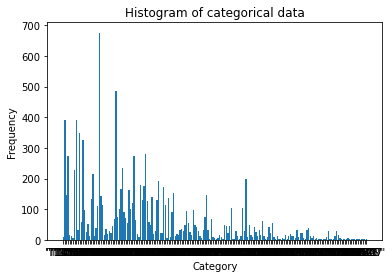

In [89]:
import matplotlib.pyplot as plt
from collections import Counter

def calculate_support(lists):
    value_counts = {}
    total_values = 0
    for lst in lists:
        for value in lst:
            value_counts[value] = value_counts.get(value, 0) + 1
            total_values += 1
    return {value: count / total_values for value, count in value_counts.items()}


support = calculate_support(aprList)

data = aprList

# Flatten the list of lists
flattened_data = [item for sublist in data for item in sublist]

# Count the occurrences of each category
histogram = Counter(flattened_data)

plt.bar(histogram.keys(), histogram.values())
plt.title("Histogram of categorical data")
plt.xlabel("Category")
plt.ylabel("Frequency")
plt.show()


In [90]:
numTTPs = 185 + 367
numObserved = len(histogram.keys())
ruleObservations = []
for rule in rules:
    ruleObservations.append([x for x in rule.lhs+rule.rhs])
ruleObservations = [item for sublist in ruleObservations for item in sublist]
numRuleObs = len(set(ruleObservations))

In [82]:
numRuleObs

51

In [58]:
def calculate_support(lists):
    value_counts = {}
    total_values = 0
    for lst in lists:
        for value in lst:
            value_counts[value] = value_counts.get(value, 0) + 1
            total_values += 1
    return {value: count / total_values for value, count in value_counts.items()}


support = calculate_support(aprList)

In [87]:
# for val in support:
#     print(val)

In [ ]:
'''
to get:

- raw data: table of rules with metrics
- json files and screenshot for visualization
'''

In [75]:
def extract_rules(rules):
    data = []
    for rule in rules:
        row = [str(rule.lhs) + " -> " + str(rule.rhs), rule.confidence, rule.support, rule.lift]
        data.append(row)
    ruleDF = pd.DataFrame(data, columns=["Rule", "Confidence", "Support", "Lift"])
    return ruleDF

In [76]:
rdf = extract_rules(rules)


In [78]:
rdf.to_csv("AbstractRules.csv", encoding='utf-8', index=False)

In [77]:
rdf.head()

,Rule,Confidence,Support,Lift
0,"(""'T1003'"",) -> (""'T1059'"",)",0.709302,0.081769,1.259856
1,"(""'T1564'"",) -> (""'T1059'"",)",0.757576,0.100536,1.345599
2,"(""'T1562'"",) -> (""'T1059'"",)",0.776596,0.097855,1.379382
3,"(""'T1555'"",) -> (""'T1059'"",)",0.755814,0.087131,1.342470
4,"(""'T1553'"",) -> (""'T1059'"",)",0.739130,0.068365,1.312836
